## Affordability

Based on definition of affordability from Australian Institute of Health and Welfare, housing affordability can be expressed as the ratio of housing costs to gross household income (ABS 2022a). 

Hence we use: 2020 Jun rent price and 2020 median income data to calculate affordability index.
2024 Jun rent price: based on SA2 region, match the year for newest median income data.
2020 median income: based on SA2 region, the newest accurate income data we can find.

Reference: https://www.aihw.gov.au/reports/australias-welfare/housing-affordability#:~:text=Measures%20relating%20to%20housing%20affordability,mortgage%20payments%20(ABS%202022a).


In [1]:
# First, make sure you have imported the necessary libraries
import pandas as pd

# Define the correct path to the dataset
data_path = '../../data/curated/final_merged_data_sa2.csv'

# Load the dataset
data = pd.read_csv(data_path)

# Selecting relevant columns for affordability: 'SA2', 'median_income_2020', 'Jun 2020 median'
affordability_columns = ['SA2', 'median_income_2020', 'Jun 2020 median']
affordability_data = data[affordability_columns].dropna()

# Calculating the monthly income by dividing the annual income by 12
affordability_data['monthly_income'] = affordability_data['median_income_2020'] / 12

# Calculating the rent-to-income ratio (rent divided by monthly income)
affordability_data['rent_income_ratio'] = affordability_data['Jun 2020 median'] / affordability_data['monthly_income']

# Display the SA2 (suburb name) along with the rent-to-income ratio
affordability_result = affordability_data[['SA2', 'rent_income_ratio']].sort_values(by='rent_income_ratio')


# Display the result
affordability_result.head()


,SA2,rent_income_ratio
50,Nhill Region,0.046120
148,Wilsons Promontory,0.048886
57,Yarriambiack,0.059437
69,Swan Hill Surrounds,0.064004
66,Buloke,0.064123


## Liveability

Based on Australian Urban Observatory (Reference: https://auo.org.au/portal/metadata/urban-liveability-index/#:~:text=The%2013%20measures%20which%20comprise,to%20fresh%20food%3B%20access%20to)

The Liveability Index is a composite score based on measures related to aspects of liveability including Social Infrastructure, Walkability, Public Transport, Public Open Space, Housing Affordability, and Local Employment.

The 13 measures which comprise the liveability index are: street connectivity; dwelling density; access to community, culture and leisure destinations; access to childcare services; access to public schools; access to health services; access to sport and recreation facilities; access to fresh food; access to convenience stores; access to regular public transport; access to large public open space; low housing affordability stress; and local employment opportunities.

Combine with the data we have from ABS, we consider following key factors:
1. Dwelling Density: use population_density to measure
2. Access to Community, Culture, and Leisure Destinations: use the entertainments_count_entertainments_count column
3. Access to Childcare Services & Access to Public Schools: use the school1_count and school2_count columns
4. Access to Health Services: Use the hospital_count_hospital_count column
5. Access to Sport and Recreation Facilities & Large Public Open Space: The park_count_park_count column can be used as a proxy for public recreation spaces
6. Access to Fresh Food & Convenience Stores: use shop_count_shop_count
7. Access to Regular Public Transport: Use the transport-related columns: stops_datavic_count_bus station, stops_datavic_count_train station, and stops_datavic_count_tram station
8. Low Housing Affordability Stress: affordability_result
9. Local Employment Opportunities: use nJob
10. crime_rate

we can categorize them into four main categories:
1. Amenities (Facilities & Services)
This category focuses on the availability of key facilities and services in the suburb that improve the quality of life.

Parks and public open spaces: park_count_park_count
Schools: school1_count, school2_count
Healthcare services: hospital_count_hospital_count
Shops and convenience stores: shop_count_shop_count


2. Safety
Safety is a crucial aspect of liveability, which can be represented by factors such as crime rates.

Crime Rate: Median Criminal Count, nHomeless_2021


3. Accessibility
Accessibility refers to the ease with which residents can travel to important locations, such as workplaces, and the availability of properties.

Public Transport: Access to bus, train, and tram stations (stops_datavic_count_bus station, stops_datavic_count_train station, stops_datavic_count_tram station)
Distance to CBD


4. Affordability
Affordability refers to the cost of living in a suburb, particularly the cost of housing relative to income.

Housing Affordability: Rent-to-income ratio, which we already calculated using median_income_2020 and Jun 2020 median
Local Employment Opportunities: nEmployed_2021, nJob_2020


In [2]:
# First, make sure you have imported the necessary libraries
import pandas as pd

# Define the correct path to the dataset
data_path = '../../data/curated/final_merged_data_sa2.csv'

# Load the dataset
data = pd.read_csv(data_path)

# Step 1: Affordability (continuing from the existing code)
affordability_columns = ['SA2', 'median_income_2020', 'Jun 2020 median', 'nEmployed_2021', 'nJob_2020']
affordability_data = data[affordability_columns].dropna()

# Calculating the monthly income by dividing the annual income by 12
affordability_data['monthly_income'] = affordability_data['median_income_2020'] / 12

# Calculating the rent-to-income ratio (rent divided by monthly income)
affordability_data['rent_income_ratio'] = affordability_data['Jun 2020 median'] / affordability_data['monthly_income']

# Normalizing affordability (lower rent-to-income ratio is better, so invert the score)
affordability_data['normalized_affordability'] = 1 - (affordability_data['rent_income_ratio'] - affordability_data['rent_income_ratio'].min()) / (affordability_data['rent_income_ratio'].max() - affordability_data['rent_income_ratio'].min())

# Normalize employment-related columns (higher is better)
affordability_data['normalized_employment'] = (affordability_data['nEmployed_2021'] - affordability_data['nEmployed_2021'].min()) / (affordability_data['nEmployed_2021'].max() - affordability_data['nEmployed_2021'].min())
affordability_data['normalized_jobs'] = (affordability_data['nJob_2020'] - affordability_data['nJob_2020'].min()) / (affordability_data['nJob_2020'].max() - affordability_data['nJob_2020'].min())

# Combine affordability with employment into the final affordability score
affordability_data['affordability_score'] = (affordability_data['normalized_affordability'] +
                                             affordability_data['normalized_employment'] +
                                             affordability_data['normalized_jobs']) / 3

# Step 2: Amenities
data['normalized_parks'] = (data['park_count'] - data['park_count'].min()) / (data['park_count'].max() - data['park_count'].min())
data['normalized_schools'] = (data['school1_count'] + data['school2_count'] - (data['school1_count'] + data['school2_count']).min()) / ((data['school1_count'] + data['school2_count']).max() - (data['school1_count'] + data['school2_count']).min())
data['normalized_health'] = (data['hospital_count'] - data['hospital_count'].min()) / (data['hospital_count'].max() - data['hospital_count'].min())
data['normalized_shops'] = (data['shop_count'] - data['shop_count'].min()) / (data['shop_count'].max() - data['shop_count'].min())

data['amenities_score'] = (data['normalized_parks'] +
                           data['normalized_schools'] +
                           data['normalized_health'] +
                           data['normalized_shops']) / 4


# Step 3: Safety (including nHomeless_2021)
# Normalize crime rate (lower is better) and homelessness (lower is better)
data['normalized_crime'] = 1 - (data['Median Criminal Count'] - data['Median Criminal Count'].min()) / (data['Median Criminal Count'].max() - data['Median Criminal Count'].min())
data['normalized_homelessness'] = 1 - (data['nHomeless_2021'] - data['nHomeless_2021'].min()) / (data['nHomeless_2021'].max() - data['nHomeless_2021'].min())

# Combine crime rate and homelessness into the final safety score
data['safety_score'] = (data['normalized_crime'] + data['normalized_homelessness']) / 2

# Step 4: Accessibility
# Normalize the 'stops_datavic_count' column
data['normalized_transport_access'] = (
    data['stop_count'] - data['stop_count'].min()) / (
    data['stop_count'].max() - data['stop_count'].min())


# Normalize distance to CBD (smaller distance is better, so we invert it)
data['normalized_distance_to_cbd'] = 1 - (
    (data['distance_to_cbd'] - data['distance_to_cbd'].min()) / 
    (data['distance_to_cbd'].max() - data['distance_to_cbd'].min()))

# Combine normalized transport access and normalized distance to CBD into the accessibility score
data['accessibility_score'] = (data['normalized_transport_access'] + data['normalized_distance_to_cbd']) / 2


# Step 5: Merge affordability with the main dataset
merged_data = pd.merge(data, affordability_data[['SA2', 'affordability_score']], on='SA2')

# Step 6: Calculate the overall Liveability Index as the weighted sum of all factors
weights = {
    'amenities_score': 1,
    'safety_score': 1,
    'accessibility_score': 1,
    'affordability_score': 1
}

merged_data['liveability_index'] = (
    merged_data['amenities_score'] * weights['amenities_score'] +
    merged_data['safety_score'] * weights['safety_score'] +
    merged_data['accessibility_score'] * weights['accessibility_score'] +
    merged_data['affordability_score'] * weights['affordability_score']
) / sum(weights.values())

# Step 7: Display the top suburbs by liveability index
top_liveable_suburbs = merged_data[['SA2', 'liveability_index']].sort_values(by='liveability_index', ascending=False).head(10)


# Display the result
top_liveable_suburbs

,SA2,liveability_index
392,Berwick - North,0.721430
356,Oakleigh - Huntingdale,0.714028
184,Preston - East,0.710981
131,Wonthaggi - Inverloch,0.708427
417,Carrum Downs,0.697041
360,Blackburn,0.695985
421,Langwarrin,0.686877
328,Wantirna South,0.684836
375,Lilydale - Coldstream,0.681768
362,Box Hill,0.680621


In [3]:
import pandas as pd

# Assuming 'merged_data' contains the liveability index and the four area scores
# Filter the top 3 suburbs by liveability index
top_3_suburbs = merged_data.nlargest(3, 'liveability_index')[['SA2', 'amenities_score', 'safety_score', 'accessibility_score', 'affordability_score', 'liveability_index']]

# Display the table of the top 3 suburbs
top_3_table = top_3_suburbs.rename(columns={
    'amenities_score': 'Amenities Score',
    'safety_score': 'Safety Score',
    'accessibility_score': 'Accessibility Score',
    'affordability_score': 'Affordability Score',
    'liveability_index': 'Liveability Index'
})

print(top_3_table)


                        SA2  Amenities Score  Safety Score  \
392         Berwick - North         0.435274      0.838522   
356  Oakleigh - Huntingdale         0.299501      0.834814   
184          Preston - East         0.289174      0.827434   

     Accessibility Score  Affordability Score  Liveability Index  
392             0.852955             0.758970           0.721430  
356             0.945560             0.776237           0.714028  
184             0.956163             0.771151           0.710981  


Plot saved at ../../plots/radar_chart_top_3_regions.png


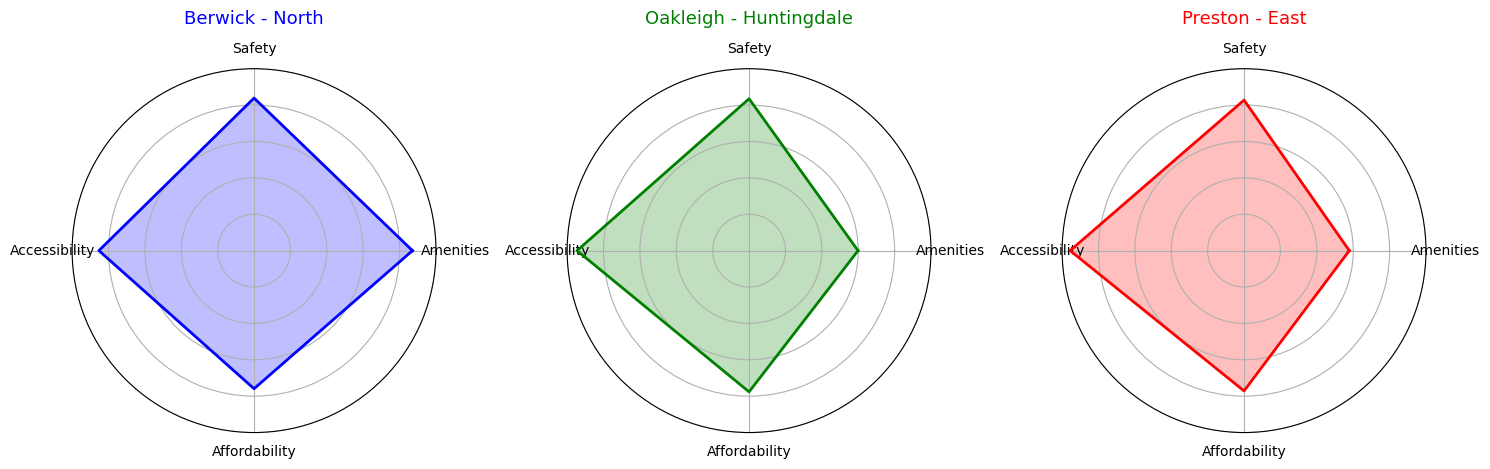

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append('../..') 
from scripts.save_plot import save_plot

# Assuming 'data' contains the accessibility scores for each region
# Select top 3 regions by liveability index for the radar plot
top_3_regions = merged_data.nlargest(3, 'liveability_index')[['SA2', 'amenities_score', 'safety_score', 'accessibility_score', 'affordability_score']]

# Prepare data for the radar plot
categories = ['Amenities', 'Safety', 'Accessibility', 'Affordability']
num_vars = len(categories)

# Function to create radar chart for each region
def create_radar_chart(ax, data, title, color):
    # Split the circle into equal parts for each category
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # Complete the circle
    data += data[:1]
    angles += angles[:1]
    
    # Plot data
    ax.fill(angles, data, color=color, alpha=0.25)
    ax.plot(angles, data, color=color, linewidth=2)
    
    # Set consistent radial limits for all categories
    ax.set_ylim(0, 1)  # The overall max limit for most categories is 1

    ax.set_yticklabels([])  # Remove the radial labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(title, size=13, color=color, y=1.1)

# Modify the amenities score to scale to 2 (so in the plot, max value of amenities = 0.5)
top_3_regions['amenities_score'] = top_3_regions['amenities_score'] * 2

# Create a radar chart for top 3 regions
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(polar=True))

# Assign colors for the regions
colors = ['b', 'g', 'r']

# Create radar chart for each region
for i, (index, row) in enumerate(top_3_regions.iterrows()):
    create_radar_chart(axs[i], row[1:].tolist(), row['SA2'], colors[i])

plt.tight_layout()

# Save the plot using the save_plot function
save_plot(fig, 'radar_chart_top_3_regions.png', output_dir='../../plots')

plt.show()



Plot saved at ../../plots/liveability_heatmap.png


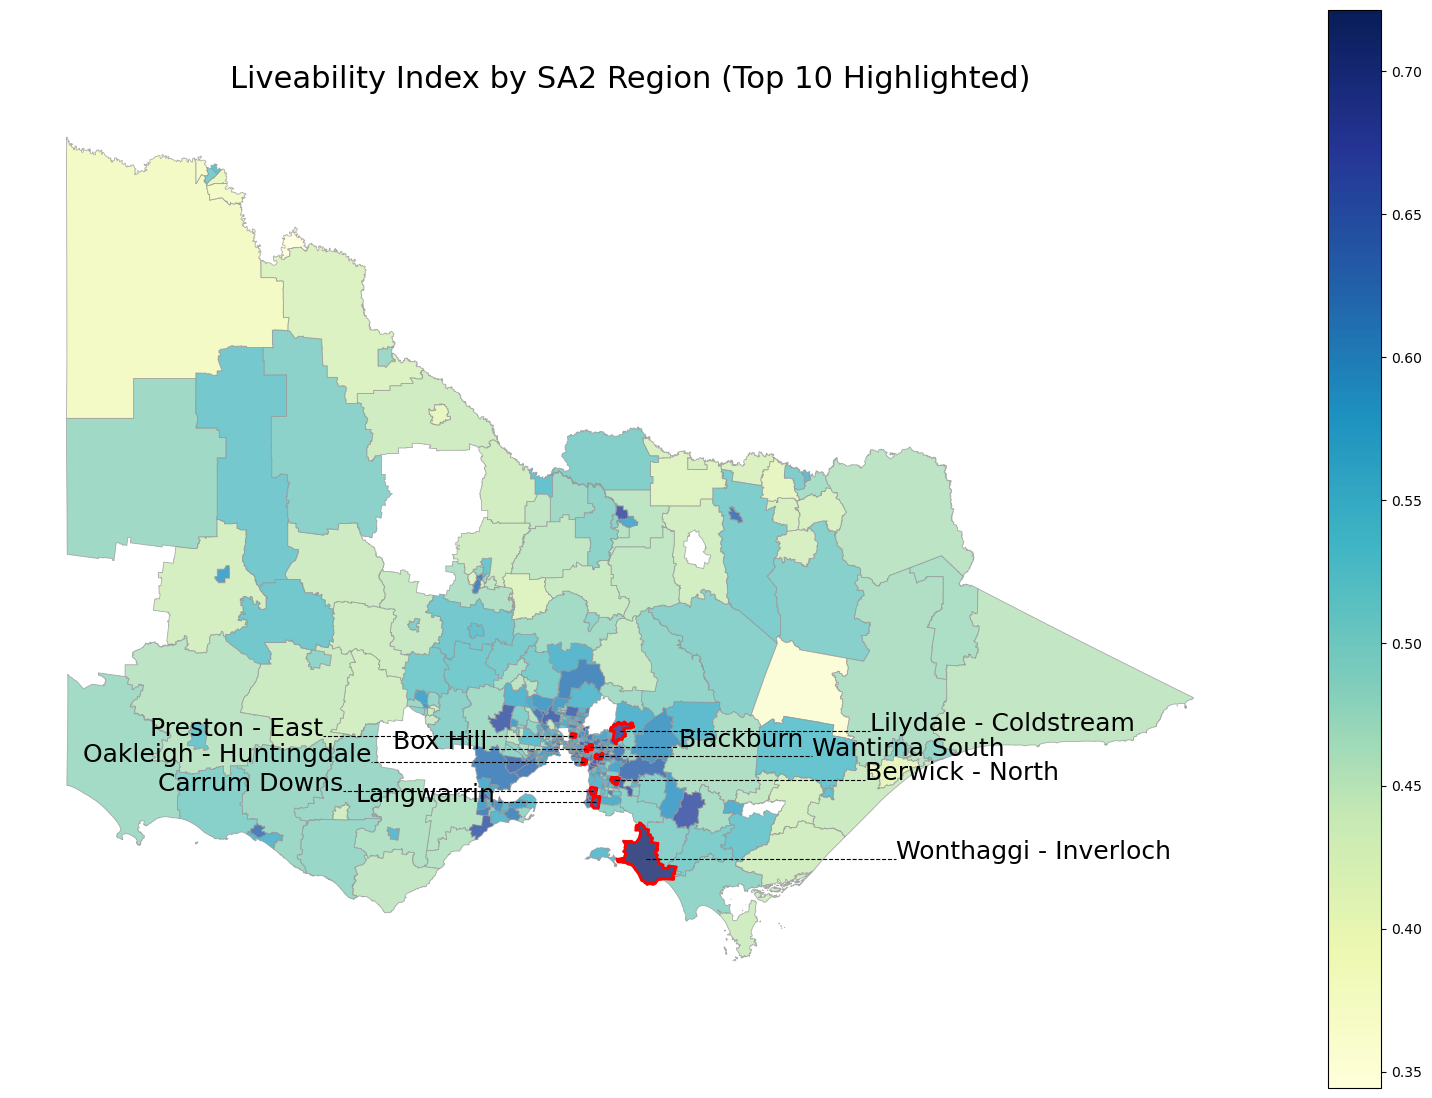

In [5]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import sys
sys.path.append('../..') 
from scripts.save_plot import save_plot

# Step 1: Load the SA2 shapefile
shapefile_path = os.path.join('../..', 'data', 'landing', 'region_data', 'sa2_dataset', 'sa2_unzip', 'SA2_2021_AUST_GDA2020.shp')
sa2_shapefile = gpd.read_file(shapefile_path)

# Step 2: Load the liveability data
liveability_data = merged_data[['SA2', 'liveability_index']]

# Step 3: Merge the shapefile data with the liveability data
sa2_shapefile = sa2_shapefile.merge(liveability_data, left_on='SA2_NAME21', right_on='SA2')

# Step 4: Identify the top 10 regions based on liveability index
top_10_regions = sa2_shapefile.nlargest(10, 'liveability_index')

# Step 5: Plot the heatmap with improved aesthetics
fig, ax = plt.subplots(1, 1, figsize=(20, 14))

# Create the heatmap for all regions using a smoother color map and transparency
sa2_shapefile.plot(column='liveability_index', 
                   cmap='YlGnBu',  # A smooth color map
                   linewidth=0.6, 
                   edgecolor='0.6',  # Thinner, more subtle borders
                   ax=ax, 
                   legend=True, 
                   alpha=0.8)  # Transparency for better readability

# Step 6: Highlight top 10 regions with a thicker boundary and different color
top_10_regions.boundary.plot(ax=ax, linewidth=2, color='red')

# Step 7: Improved label placement for the top 10 regions with better offsets
for idx, row in top_10_regions.iterrows():
    centroid = row['geometry'].centroid
    label_x_offset, label_y_offset = centroid.x, centroid.y  # Initialize coordinates
    
    # Adjust the placement based on the region's relative position
    if row['SA2_NAME21'] in ['Berwick - North', 'Wonthaggi - Inverloch', 'Lilydale - Coldstream']:
        label_x_offset += 2  # Move label right
        ha_alignment = 'left'
    elif row['SA2_NAME21'] in ['Preston - East', 'Carrum Downs']:
        label_x_offset -= 2  # Move label left
        ha_alignment = 'right'
    elif row['SA2_NAME21'] in ['Langwarrin', 'Box Hill']:
        label_x_offset -= 0.8  # Move label slightly left
        ha_alignment = 'right'
    elif row['SA2_NAME21'] in ['Oakleigh - Huntingdale']:
        label_x_offset -= 1.7  # Move label more to the left
        ha_alignment = 'right'
    elif row['SA2_NAME21'] in ['Blackburn']:
        label_x_offset += 0.7  # Move label upwards
        ha_alignment = 'left'
    elif row['SA2_NAME21'] in ['Wantirna South']:
        label_x_offset += 1.7  # Move label upwards
        ha_alignment = 'left'
    else:
        label_y_offset -= 2  # Move label downwards
        ha_alignment = 'center'
    
    # Plot the label with improved font size and color
    ax.text(label_x_offset, label_y_offset, row['SA2_NAME21'], fontsize=18, color='black', ha=ha_alignment)

    # Draw a cleaner line from the centroid to the label
    ax.plot([centroid.x, label_x_offset], [centroid.y, label_y_offset], color='black', linewidth=0.8, linestyle='--')

# Set the title with a larger font size
plt.title('Liveability Index by SA2 Region (Top 10 Highlighted)', fontsize=22)

# Remove the axis for a cleaner appearance
ax.set_axis_off()

# Save the plot using save_plot function
save_plot(fig, 'liveability_heatmap.png', output_dir='../../plots')

# Show the plot
plt.show()
